In [1]:
# panda library to read csv file
import pandas as pd

# string library to use stopword dictionary
import string as str

# numpy for stronger caculate
import numpy as np

# nltk library to lemmatize or stemming word
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

#download all the necessary resource
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

#re library to filter the text
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Hi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    len label                                               text  label_num
0   605   ham  Subject: enron methanol ; meter # : 988291\r\n...          0
1  2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...          0
2  3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...          0
3  4685  spam  Subject: photoshop , windows , office . cheap ...          1
4  2030   ham  Subject: re : indian springs\r\nthis deal is t...          0


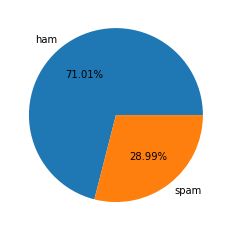

In [2]:
df=pd.read_csv("spam_ham_dataset.csv")
print(df.head(5))
plt.pie(df['label'].value_counts(), labels = ['ham','spam'],autopct='%.2f%%')
plt.show()

In [3]:
def pre_process(text):
    #lower case all the text
    text_lower=text.lower()
    #remove all the url in the text
    text_no_link=re.sub(r"http\S+", "", text_lower)
    #remove all digit,punctuation,... and only keep the alphabetic words
    text_clean=re.sub(r'[^a-z]', ' ', text_no_link)
    text_clean=" ".join(text_clean.split())
    #use wordnet lemmatizer to lemmatize the text
    wnl = WordNetLemmatizer()
    #tokenize to make array of words
    words = word_tokenize(text_clean)
    #remove all stop word such as a,he,she,many,...
    word_no_stop=[word for word in words if word not in stopwords.words('english')]
    #lemmatize all the text
    word_lemmatize=[wnl.lemmatize(word) for word in word_no_stop]
    #remove duplicate
    word_lemmatize_no_dup=list(dict.fromkeys(word_lemmatize))
    #return the final result
    return word_lemmatize_no_dup

In [4]:
df["text"]=df["text"].apply(pre_process)

In [5]:
df.head(5)

,len,label,text,label_num
0,605,ham,"[subject, enron, methanol, meter, follow, note...",0
1,2349,ham,"[subject, hpl, nom, january, see, attached, fi...",0
2,3624,ham,"[subject, neon, retreat, ho, around, wonderful...",0
3,4685,spam,"[subject, photoshop, window, office, cheap, ma...",1
4,2030,ham,"[subject, indian, spring, deal, book, teco, pv...",0


In [6]:
train_set = df.sample(frac=0.8,random_state=1).reset_index(drop=True)
test_set = df.drop(train_set.index).reset_index(drop=True)
train_set = train_set.reset_index(drop=True)

In [7]:
#about 16s
#--------create vocabulary dictionary for the train set---------

#list of distinct words in the vocabulary
vocabulary = list(set(train_set['text'].sum()))

#for each vocabulary word assign it with a value: empty list
listarr=np.empty((len(vocabulary), 0)).tolist()
vocab=dict(zip(vocabulary,listarr))

#initialize the value of each empty list [0,0]
#the first value of this list is the frequency of word that appear in the ham email
#for the second is the frequency of word that appear in spam email
vocab.update((k,[0,0]) for k in vocab) 

In [8]:
train_size=train_set.shape[0]
for i in range(train_size):
    for word in train_set['text'][i]:
      if(train_set['label'][i]=='ham'):
        vocab[word][0]+=1 
      if(train_set['label'][i]=='spam'):
        vocab[word][1]+=1

In [9]:
#number of spam email in the training set
num_of_spam = train_set['label'].value_counts()['spam']

#number of ham email in the training set
num_of_ham = train_set['label'].value_counts()['ham']

#probality of spam email in the training set
p_spam =  num_of_spam / train_size

#probality of ham email in the training set
p_ham =  num_of_ham / train_size


#function to caculate P(word[i]|spam)
def p_spam_word(word):
    if word in vocab:
      return (vocab[word][1]+1)/(num_of_spam+2)
    else:
      return 1/(num_of_spam+2)

#function to caculate P(word[i]|ham)
def p_ham_word(word):
  if word in vocab:
      return (vocab[word][0]+1)/(num_of_ham+2)
  else:
      return 1/(num_of_ham+2)
def classify(message):
    p_spam_messge = np.log10(p_spam)
    p_ham_messge = np.log10(p_ham)
    for word in message:
        p_spam_messge += np.log10(p_spam_word(word))
        p_ham_messge += np.log10(p_ham_word(word))
    if p_ham_messge >= p_spam_messge:
        return 'ham'
    elif p_ham_messge < p_spam_messge:
        return 'spam'  

In [10]:
#------------------training--------------------
train_set['predict'] = train_set['text'].apply(classify)
correct_train = (train_set['predict'] == train_set['label']).sum() / train_size * 100 #in %
print(correct_train)

94.0053178631859


In [14]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(train_set['label'],train_set['predict'],digits=4))
print(confusion_matrix(train_set['label'],train_set['predict']))
print(accuracy_score(train_set['label'],train_set['predict']))

              precision    recall  f1-score   support

         ham     0.9923    0.9224    0.9561      2926
        spam     0.8398    0.9827    0.9056      1211

    accuracy                         0.9401      4137
   macro avg     0.9160    0.9525    0.9309      4137
weighted avg     0.9476    0.9401    0.9413      4137

[[2699  227]
 [  21 1190]]
0.9400531786318589


In [11]:
test_set['predict'] = test_set['text'].apply(classify)
correct_test = (test_set['predict'] == test_set['label']).sum() / test_set.shape[0] *100 #in %
print(correct_test)

94.1972920696325


In [12]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(test_set['label'],test_set['predict'],digits=4))
print(confusion_matrix(test_set['label'],test_set['predict']))
print(accuracy_score(test_set['label'],test_set['predict']))

              precision    recall  f1-score   support

         ham     0.9955    0.9202    0.9563       714
        spam     0.8476    0.9906    0.9135       320

    accuracy                         0.9420      1034
   macro avg     0.9215    0.9554    0.9349      1034
weighted avg     0.9497    0.9420    0.9431      1034

[[657  57]
 [  3 317]]
0.941972920696325
